### genereative model 

In [1]:
from brian2 import *
%matplotlib inline
from brian2 import SpikeGeneratorGroup
from brian2 import NeuronGroup
import numpy as np
import random
import pandas as pd

faire un modele generatif où on aurait : 
- une première couche de i neurones = nb de PGs 
- une deuxième couche où on aurait j neurones, connectés à tous les i qui génèrent des PGs en réponse à un spike émit par un i 

on aurait donc {i, j} avec par ex i emet un spike à 10ms et connecte les neurones j1, j3 et j4 qui émettent des spikes à 10ms, 15ms et 6ms respectivement 

-> on définit donc par ti le timing d'occurence d'un PG et par tj le pattern du PG

In [2]:
Ni = 5 #nb de PGs 
Nj = 10 #nb de N 
n_pattern = 5
duration = 1000*ms

a = np.arange(n_pattern)
i_syn=[]
n_syn = []

cmap = plt.cm.get_cmap("plasma")
color_dict = pd.Series({i:cmap(i/len(a)) for i,k in enumerate(a)})

In [3]:
# def des projections des neurones pré-syn, i.e. le nb de neurones constituant 1 PG

for k in range(Ni) : 
    n_j = np.random.randint(1, Nj, size = 1) # au moins 3 neurones impliqués dans un PG
    i_syn.append(random.sample(range(Nj), int(n_j))) # def les j connectés à i[k], pas de repetition, nb def au hasard par n_j
    n_syn.append(len(i_syn[k])) # pour set des poids et délais aléatoires aux synapses, voir ci-après 
    
n_syn = sum(n_syn)

In [4]:
i_indices = np.random.randint(0, Ni, size = n_pattern) # nombre de PG observé (n_pattern), de Ni sortes différentes
i_temps = np.random.rand(n_pattern)*100*ms # temps d'occurence des n_pattern PG 

a = SpikeGeneratorGroup(Ni, i_indices, i_temps)
a_spike = SpikeMonitor(a)

b = NeuronGroup(Nj, '''dv/dt = -v/tau : volt
                       tau : second''',
                    threshold= 'v > 0.01*volt',
                    reset= 'v = -0.07*volt',
                    method = 'exact')
b.tau = 0.01*second

syn = Synapses(a, b, on_pre='v+=0.1*w*volt', model = 'w:1')

for k in range(Ni):
    syn.connect(i = k , j = i_syn[k])

syn.w[:,:] = np.random.rand(n_syn)
syn.delay[:,:] = np.random.rand(n_syn)*second 
b_spike = SpikeMonitor(b)


run(duration)

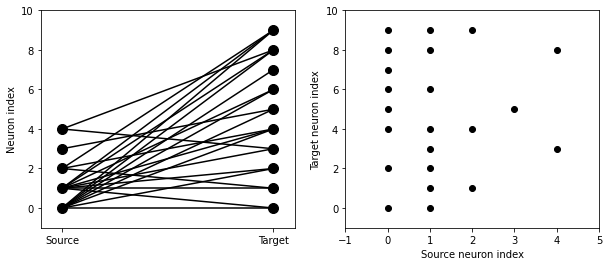

In [14]:
def visualise_connectivity(syn):
    Ns = len(syn.source)
    Nt = len(syn.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(syn.i, syn.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(syn.i, syn.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

visualise_connectivity(syn)

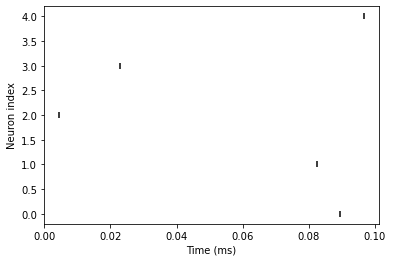

In [22]:
plt.scatter(a_spike.t, a_spike.i, color = "k", marker = "|")
xlabel('Time (ms)')
ylabel('Neuron index');

In [23]:
a_spike.t[0]

4.6 * msecond

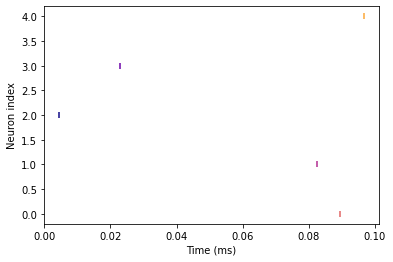

In [24]:
for i in range(n_pattern) :
    plt.scatter(a_spike.t[i], a_spike.i[i], if syn.j color = color_dict[i], marker = "|")
    xlabel('Time (ms)')
    ylabel('Neuron index');

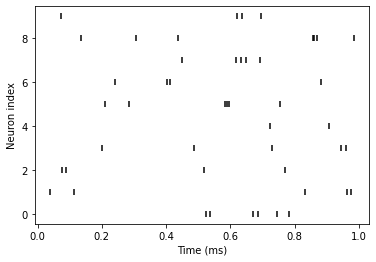

In [9]:
plt.scatter(b_spike.t, b_spike.i, color = "k", marker = "|")
xlabel('Time (ms)')
ylabel('Neuron index')

In [24]:
syn.i, syn.j

(<synapses.i: array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 4])>,
 <synapses.j: array([8, 7, 6, 4, 0, 9, 5, 2, 0, 2, 4, 9, 1, 3, 8, 6, 1, 4, 9, 5, 3, 8])>)